In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import skewnorm, rankdata

In [2]:
class createSet(object): # Make this subclass pd dataframe? #https://stackoverflow.com/questions/22155951/how-to-subclass-pandas-dataframe
    '''This creates pandas dataframe of a specified size with generated features of
    various distributions and a dependent variable of a specified skewness. 
    
    This class also has a few methods for creating additional, completely random features with 
    a function call. These can be of specified distribution but are truly random and are likely
    to have correlations close to zero with the target variable.
    
    The outlier method removes rows at random and replaces them with outliers: use "all" to get
    extreme values in every column, or specify 'columns=[]' to get outliers in only some features.
    '''
    
    def __init__(self,size=10000, targetskew=0, addCorrFeats=True):
        self.size = size
        #these two are counters that help create unique column names for generatable features later
        self.cons = 1
        self.cats = 1
        
        #create the target variable with the specified skewneww
        targetMean = 6000
        targetStd = 2000
        self.hoursSpent = skewnorm.rvs(a=targetskew,loc=targetMean,scale=targetStd, size=self.size)
        df = pd.DataFrame(self.hoursSpent, columns=['hoursSpent'])
        
        #Some of the features will be calculated using the target variable to artificially create some
        # correlation. However, I don't want them to automatically inherit the skewness of the target
        # variable, so instead of basing the independing variables directly on the target, I will 
        # create a normal distribution on the same scale that is sorted to match the order of the 
        # target variable. That enables creating correlated features without inheriting skew.
        sortedNormal = np.sort(skewnorm.rvs(a=0, loc=targetMean,scale=targetStd, size=self.size))
        self.normWithTargetSorting = [sortedNormal[i-1] for i in rankdata(self.hoursSpent, method='ordinal')]
        
        
        if addCorrFeats == True:
            #This adds a normally distributed feature that's typically around .65 correlation
            #df['screenActions'] = [int(x+np.random.randint(low=(targetMean - targetStd*2),
            #                        high=(targetMean + targetStd*2))) for x in self.normWithTargetSorting]
            df['screenActions'] = [int(x+np.random.normal(loc=0,scale=targetStd*1.5))
                                   for x in self.normWithTargetSorting]
            
            #This adds a uniformly distributed feature that's typically around .13 correlation
            def unif(self, p):
                return np.random.choice(a=[np.random.uniform(high=150),np.random.uniform(low=150.1,high=300)], p=p)
            df ['picsPerMonth'] = [unif(self,[.4,.6]) if x > targetMean else 
                                   unif(self,[.6,.4]) for x in self.normWithTargetSorting]
            
            #This adds a poisson distribution that's typically around .17 correlation
            df['timesDropped'] = [np.random.poisson(lam=1.5) if x > targetMean else 
                                  np.random.poisson(lam=1.0) for x in self.normWithTargetSorting]
            
            #This adds a dual-peak gamma distribution for owner age, typically around -.12 correlation
            def gam(self, p):
                return np.random.choice(a=[np.random.gamma(shape=25.0,scale=1),
                              np.random.gamma(shape=25.0,scale=1.8)], p=p)
            df['ownerAge'] = [gam(self,[.6,.4]) if x >targetMean else 
                              gam(self,[.4,.6]) for x in self.normWithTargetSorting]
            
            #This adds a bernoulli distribution for whether the phone is rooted, typically around .06 correlation
            df['rooted'] = [np.random.binomial(1, .05) if x > targetMean*1.5 else
                            np.random.binomial(1, .005) for x in self.normWithTargetSorting]
            
            #This adds a categorical variable that slightly corresponds to the target
            def osChoice(self, p):
                return np.random.choice(a=['iOS', 'Android', 'other'], p=p)
            df ['os'] = [osChoice(self,[.415,.575,.01]) if x > targetMean else 
                                   osChoice(self,[.335,.635,.03]) for x in self.normWithTargetSorting]
               
        self.df = df
        
    def addContFeatures(self, feats={'normal':1}):
        for shape, cnt in feats.items():
            if shape == 'normal':
                for j in range(cnt):
                    Y = np.random.normal(loc=targetMean,scale=targetStd, size=self.size)
                    self.df['normalFeat_'+str(self.cons)] = Y
                    self.cons=self.cons+1
            elif shape == 'uniform':
                for j in range(cnt):
                    Y = np.random.uniform(size=self.size)*(targetMean*2)
                    self.df['uniformFeat_'+str(self.cons)] = Y
                    self.cons=self.cons+1
            elif shape == 'poisson':
                for j in range(cnt):
                    Y = np.random.poisson(lam=1.0,size=self.size)
                    self.df['poissonFeat_'+str(self.cons)] = Y
                    self.cons=self.cons+1
            elif shape == 'gamma':
                for j in range(cnt):
                    Y = np.random.gamma(shape=2.0,scale=2,size=self.size)
                    self.df['gammaFeat_'+str(self.cons)] = Y
                    self.cons=self.cons+1
                    
                
            else:
                print('NOTE: received invalid distribution type. Try \"normal\", \"uniform\", or ')
    
    def addCatFeatures(self, feats={'sex':['male', 'female']}):
        for name, values in feats.items():
            odds = np.random.randint(low=0, high=len(values),size=self.size)
            self.df[name] = [values[x] for x in odds]
            del odds
            
    def addOutliers(self, cnt=5):
        #code this
        self.df = df
        
        
        
            
        

In [3]:
#this cell doesn't need to run; It checks 100 iterations of the class createSet() to see how the features
# tend to correlate with the target variable (given that they are generated dynamically)
#It's only useful when I update how a feature is calculated

import time
start = time.time()
screencorrs = []
picscorrs = []
dropscorrs = []
agecorrs = []
rootcorrs = []
for i in range(100):
    u = createSet(size=1000)
    cor = u.df.corr()
    screencorrs.append(cor.loc['hoursSpent','screenActions'])
    picscorrs.append(cor.loc['hoursSpent','picsPerMonth'])
    dropscorrs.append(cor.loc['hoursSpent','timesDropped'])
    agecorrs.append(cor.loc['hoursSpent','ownerAge'])
    rootcorrs.append(cor.loc['hoursSpent','rooted'])
print('Correlations: \n')
print('screenActions\n',np.mean(screencorrs),'\n', np.std(screencorrs), '\n')
print('picsPerMonth\n',np.mean(picscorrs),'\n', np.std(picscorrs), '\n')
print('timesDropped\n',np.mean(dropscorrs),'\n', np.std(dropscorrs), '\n')
print('ownerAge\n',np.mean(agecorrs),'\n', np.std(agecorrs), '\n')
print('rooted\n',np.mean(rootcorrs),'\n', np.std(rootcorrs), '\n')
print('done in ', time.time() - start, 'seconds')


Correlations: 

screenActions
 0.5516624124202112 
 0.02348374103212641 

picsPerMonth
 0.13947301170815524 
 0.03450739960575725 

timesDropped
 0.17160394592276493 
 0.03196219466483387 

ownerAge
 -0.1362055065172185 
 0.03442890236984881 

rooted
 0.06661203288199367 
 0.03949716106007595 

done in  9.712706327438354 seconds


---------------------------------------------------------------------------

---------------------------------------------------------------------------

---------------------------------------------------------------------------

---------------------------------------------------------------------------

_________________

In [4]:
#Let's create one for vizualization

viz = createSet(targetskew=0)
print(viz.df.shape)
display(viz.df.head())
viz.df.corr()

(10000, 7)


,hoursSpent,screenActions,picsPerMonth,timesDropped,ownerAge,rooted,os
0,8956.315587,9631,238.965082,3,28.212023,0,iOS
1,6365.225433,-379,239.694145,3,26.237737,0,Android
2,5739.015518,7942,260.274070,2,52.900196,0,Android
3,5498.979390,2257,90.258255,0,35.252037,0,Android
4,6922.374494,6669,72.478976,0,25.495472,0,iOS


,hoursSpent,screenActions,picsPerMonth,timesDropped,ownerAge,rooted
hoursSpent,1.000000,0.553316,0.144610,0.196869,-0.111010,0.062081
screenActions,0.553316,1.000000,0.077235,0.097170,-0.056571,0.032543
picsPerMonth,0.144610,0.077235,1.000000,0.050641,-0.036311,0.007841
timesDropped,0.196869,0.097170,0.050641,1.000000,-0.033198,-0.004056
ownerAge,-0.111010,-0.056571,-0.036311,-0.033198,1.000000,-0.000241
rooted,0.062081,0.032543,0.007841,-0.004056,-0.000241,1.000000


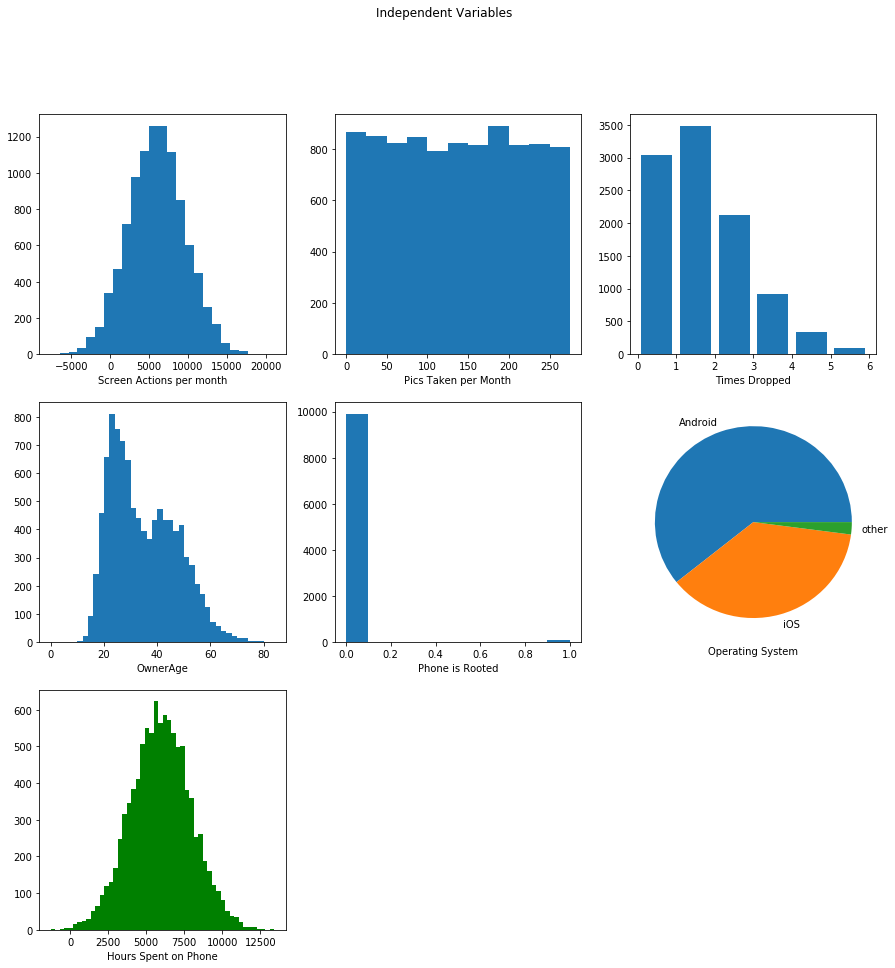

In [6]:
#Core feature Histograms

plt.figure(figsize=(15,15))
plt.suptitle('Independent Variables')
plt.subplot(331)
plt.hist(viz.df.screenActions, bins=25)
plt.xlabel('Screen Actions per month')
plt.subplot(332)
plt.hist(viz.df.picsPerMonth, bins=np.arange(0,max(viz.df.picsPerMonth),25))
plt.xlabel('Pics Taken per Month')
plt.subplot(333)
plt.hist(viz.df.timesDropped, bins=np.arange(0,max(viz.df.timesDropped),1), rwidth = .8)
plt.xlabel('Times Dropped')
plt.subplot(334)
plt.hist(viz.df.ownerAge, bins=np.arange(0,max(viz.df.ownerAge),2))
plt.xlabel('OwnerAge')
plt.subplot(335)
plt.hist(viz.df.rooted)#, bins=np.arange(0,40,3))
plt.xlabel('Phone is Rooted')
plt.subplot(336)
viz.df['os'].value_counts().plot(kind='pie')
plt.xlabel('Operating System')
plt.ylabel('')
plt.subplot(337)
plt.hist(viz.df.hoursSpent, color='g', bins=50)#, bins=np.arange(0,40,3))
plt.xlabel('Hours Spent on Phone')

plt.show()







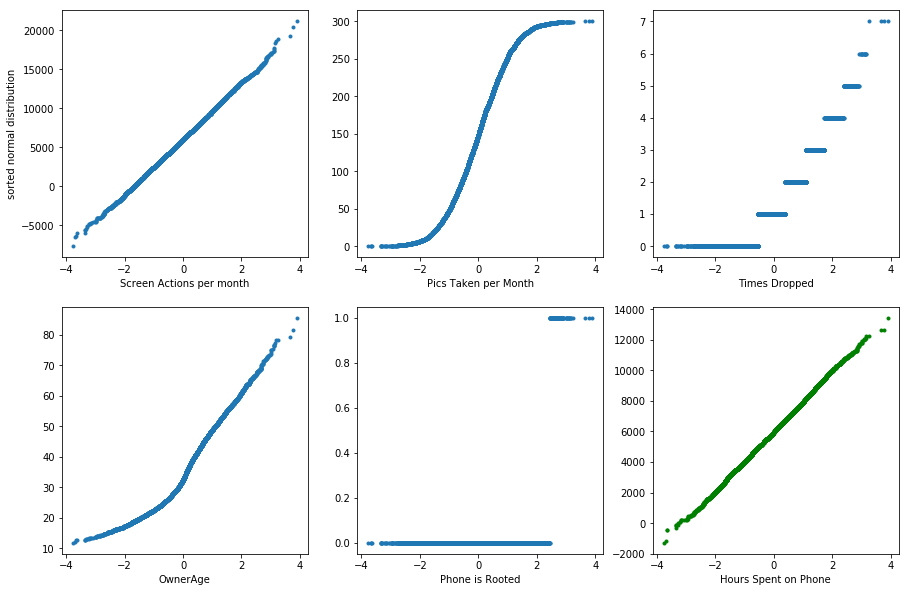

In [7]:
#Quartile Plot compared to random normal

norm = np.random.normal(0, 1, viz.size)
norm.sort()
norm1 = viz.df['screenActions'].sort_values()
uni2 =  viz.df['picsPerMonth'].sort_values()
pois3 =  viz.df['timesDropped'].sort_values()
gamma4 = viz.df['ownerAge'].sort_values()
bern = viz.df['rooted'].sort_values()
target = viz.df['hoursSpent'].sort_values()

plt.figure(figsize=(15,10))
plt.subplot(231)
plt.plot(norm, norm1, ".")
plt.ylabel('sorted normal distribution')
plt.xlabel('Screen Actions per month')
plt.subplot(232)
plt.plot(norm, uni2, ".")
plt.xlabel('Pics Taken per Month')
plt.subplot(233)
plt.plot(norm, pois3, ".")
plt.xlabel('Times Dropped')
plt.subplot(234)
plt.plot(norm, gamma4, ".")
plt.xlabel('OwnerAge')
plt.subplot(235)
plt.plot(norm, bern, ".")
plt.xlabel('Phone is Rooted')
plt.subplot(236)
plt.plot(norm, target, "g.")
plt.xlabel('Hours Spent on Phone')
plt.show()

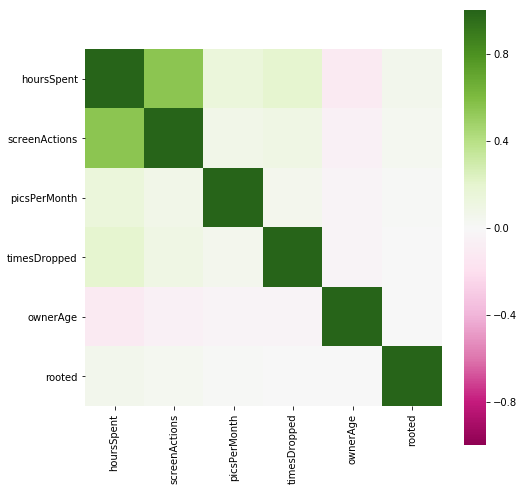

In [8]:
plt.figure(figsize=[8,8])
sns.heatmap(viz.df.corr(), vmin = -1,square=True, cmap="PiYG")
plt.show()

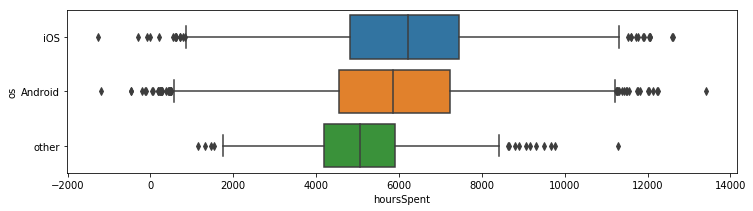

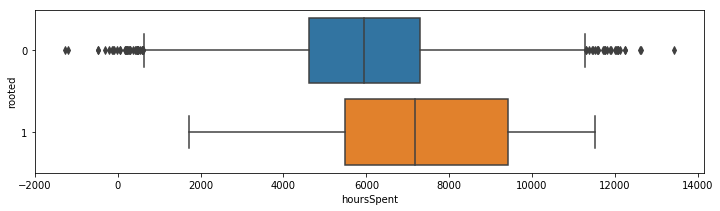

In [9]:
plt.figure(figsize=[12,3])
sns.boxplot(x='hoursSpent', y='os', data=viz.df, orient='h')
plt.show()
plt.figure(figsize=[12,3])
sns.boxplot(x='hoursSpent', y='rooted', data=viz.df, orient='h')
plt.show()

# Baseline: Linear Regression of a normally distributed dependent variable using 1 normally distributed feature

In [10]:
from sklearn import linear_model
from sklearn.model_selection import cross_val_score, cross_val_predict
import statsmodels.formula.api as smf
from statsmodels.sandbox.regression.predstd import wls_prediction_std


In [11]:
normal = createSet(targetskew=0, size=10000)
regr = linear_model.LinearRegression()

In [12]:
#sklearn
x = normal.df['screenActions']
y = normal.df['hoursSpent']
regr.fit(pd.DataFrame(x),y)
scores = cross_val_score(regr,pd.DataFrame(x),y,cv=10)
print("Fold Scores: ",scores)
print("\nAverage Score: ",np.mean(scores))
print('\nCoefficients:', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\n','-'*40)

#statsmodels

linear_formula = 'hoursSpent ~ screenActions'

# Fit the model to our data using the formula.
lm = smf.ols(formula=linear_formula, data=normal.df).fit()
lm.summary()

Fold Scores:  [0.28316385 0.2899333  0.30385886 0.30966272 0.3269409  0.30820229
 0.27436205 0.31050207 0.34669842 0.33440927]

Average Score:  0.3087733727309993

Coefficients: [0.30902412]

Intercept: 
 4168.664395721013

 ----------------------------------------


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             hoursSpent   R-squared:                       0.310
Model:                            OLS   Adj. R-squared:                  0.310
Method:                 Least Squares   F-statistic:                     4489.
Date:                Wed, 26 Dec 2018   Prob (F-statistic):               0.00
Time:                        15:12:52   Log-Likelihood:                -88324.
No. Observations:               10000   AIC:                         1.767e+05
Df Residuals:                    9998   BIC:                         1.767e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      4168.6644     32.157    129.636      0.000    4105.631    4231.698
screenActions     0.3090      0.005     67.000      0.000       0.300       0.318
==============================================================================
Omnibus:                        1.831   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.400   Jarque-Bera (JB):                1.831
Skew:                           0.033   Prob(JB):                        0.400
Kurtosis:                       2.998   Cond. No.                     1.35e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.35e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

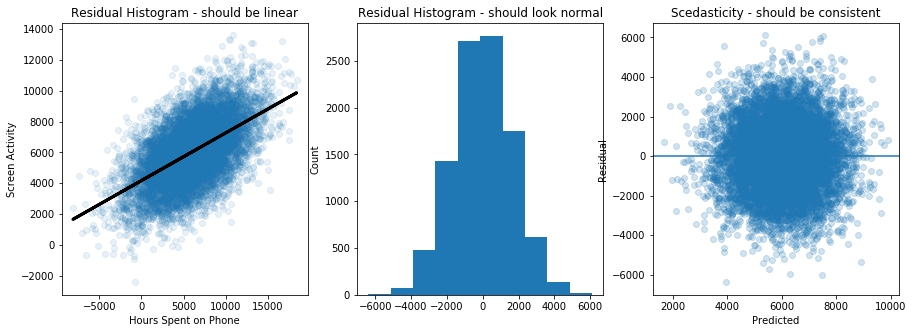

In [13]:
#Let's check how our output looks:
pred = cross_val_predict(regr,pd.DataFrame(x),y,cv=10)
residual = y - pred

plt.figure(figsize=[15,5])
plt.subplot(131)
plt.scatter(x,y, alpha=.1)
plt.plot(x, regr.predict(pd.DataFrame(x)), color='black', linewidth=3)
plt.title('Residual Histogram - should be linear')
plt.xlabel('Hours Spent on Phone')
plt.ylabel('Screen Activity')
plt.subplot(132)
plt.hist(residual)
plt.title('Residual Histogram - should look normal')
plt.ylabel('Count')
plt.subplot(133)
plt.scatter(pred, residual, alpha=.2)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Scedasticity - should be consistent')
plt.show()

# What if the target variable had a right skew instead of being normally distributed?

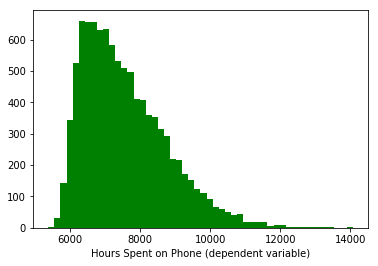

In [14]:
rightskew = createSet(targetskew=10, size=10000)
plt.hist(rightskew.df.hoursSpent, color='g', bins=50)
plt.xlabel('Hours Spent on Phone (dependent variable)')
plt.show()

regr = linear_model.LinearRegression()

In [15]:
#sklearn
x = rightskew.df['screenActions']
y = rightskew.df['hoursSpent']
regr.fit(pd.DataFrame(x),y)
scores = cross_val_score(regr,pd.DataFrame(x),y,cv=10)
print("Fold Scores: ",scores)
print("\nAverage Score: ",np.mean(scores))
print('\nCoefficients:', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\n','-'*40)
#statsmodels

linear_formula = 'hoursSpent ~ screenActions'

# Fit the model to our data using the formula.
lm = smf.ols(formula=linear_formula, data=rightskew.df).fit()
lm.summary()

Fold Scores:  [0.30315752 0.30332906 0.27312883 0.30065919 0.25027794 0.29178423
 0.28223606 0.26915508 0.28748906 0.29062602]

Average Score:  0.28518429860254485

Coefficients: [0.17780549]

Intercept: 
 6499.913628301192

 ----------------------------------------


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             hoursSpent   R-squared:                       0.287
Model:                            OLS   Adj. R-squared:                  0.287
Method:                 Least Squares   F-statistic:                     4018.
Date:                Wed, 26 Dec 2018   Prob (F-statistic):               0.00
Time:                        15:12:58   Log-Likelihood:                -83441.
No. Observations:               10000   AIC:                         1.669e+05
Df Residuals:                    9998   BIC:                         1.669e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      6499.9136     19.729    329.465      0.000    6461.241    6538.586
screenActions     0.1778      0.003     63.390      0.000       0.172       0.183
==============================================================================
Omnibus:                      922.068   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1247.515
Skew:                           0.765   Prob(JB):                    1.28e-271
Kurtosis:                       3.807   Cond. No.                     1.36e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.36e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

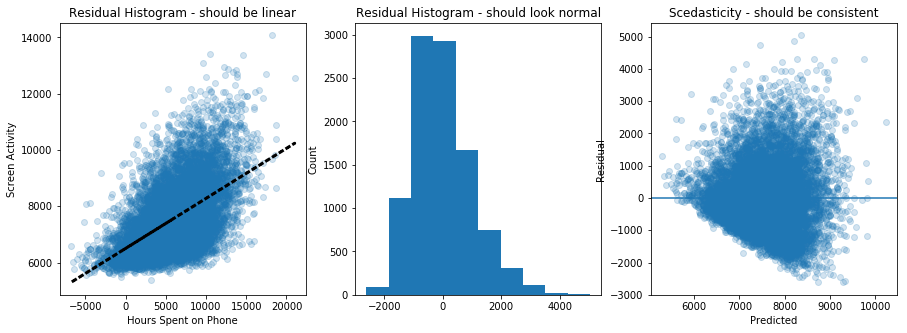

In [16]:
#Let's check how our output looks:
pred = cross_val_predict(regr,pd.DataFrame(x),y,cv=10)
residual = y - pred

plt.figure(figsize=[15,5])
plt.subplot(131)
plt.scatter(x,y, alpha=.2)
plt.plot(x, regr.predict(pd.DataFrame(x)), color='black', lw=3, ls='dotted')
plt.title('Residual Histogram - should be linear')
plt.xlabel('Hours Spent on Phone')
plt.ylabel('Screen Activity')
plt.subplot(132)
plt.hist(residual)
plt.title('Residual Histogram - should look normal')
plt.ylabel('Count')
plt.subplot(133)
plt.scatter(pred, residual, alpha=.2)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Scedasticity - should be consistent')
plt.show()

In [17]:
# If we use a transformation to reduce the skew, how much does it help?

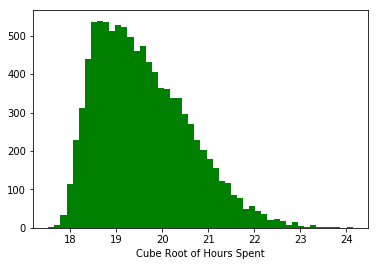

In [18]:
plt.hist(rightskew.df.hoursSpent**(1/3), color='g', bins=50)
plt.xlabel('Cube Root of Hours Spent')
plt.show()

In [19]:
rightskew.df['cube_rt_hoursSpent'] = rightskew.df['hoursSpent']**(1/3)
y = rightskew.df['cube_rt_hoursSpent']
regr.fit(pd.DataFrame(x),y)
scores = cross_val_score(regr,pd.DataFrame(x),y,cv=10)
print("Fold Scores: ",scores)
print("\nAverage Score: ",np.mean(scores))
print('\nCoefficients:', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\n','-'*40)
#statsmodels

linear_formula = 'cube_rt_hoursSpent ~ screenActions'

# Fit the model to our data using the formula.
lm = smf.ols(formula=linear_formula, data=rightskew.df).fit()
lm.summary()

Fold Scores:  [0.30662774 0.30942008 0.28348075 0.3075797  0.25662496 0.29900499
 0.28852251 0.27871902 0.29318832 0.29641483]

Average Score:  0.2919582901473366

Coefficients: [0.00015024]

Intercept: 
 18.67872657852801

 ----------------------------------------


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     cube_rt_hoursSpent   R-squared:                       0.293
Model:                            OLS   Adj. R-squared:                  0.293
Method:                 Least Squares   F-statistic:                     4151.
Date:                Wed, 26 Dec 2018   Prob (F-statistic):               0.00
Time:                        15:13:05   Log-Likelihood:                -12516.
No. Observations:               10000   AIC:                         2.504e+04
Df Residuals:                    9998   BIC:                         2.505e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        18.6787      0.016   1138.869      0.000      18.647      18.711
screenActions     0.0002   2.33e-06     64.428      0.000       0.000       0.000
==============================================================================
Omnibus:                      444.441   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              504.508
Skew:                           0.542   Prob(JB):                    2.80e-110
Kurtosis:                       3.194   Cond. No.                     1.36e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.36e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

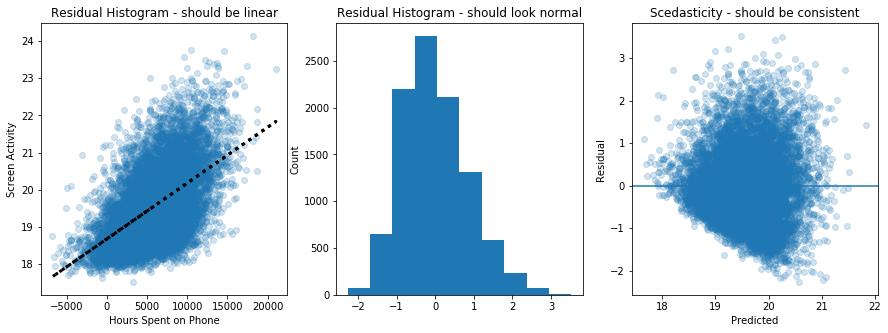

In [20]:
#Let's check how our output looks:
pred = cross_val_predict(regr,pd.DataFrame(x),y,cv=10)
residual = y - pred

plt.figure(figsize=[15,5])
plt.subplot(131)
plt.scatter(x,y, alpha=.2)
plt.plot(x, regr.predict(pd.DataFrame(x)), color='black', lw=3, ls='dotted')
plt.title('Residual Histogram - should be linear')
plt.xlabel('Hours Spent on Phone')
plt.ylabel('Screen Activity')
plt.subplot(132)
plt.hist(residual)
plt.title('Residual Histogram - should look normal')
plt.ylabel('Count')
plt.subplot(133)
plt.scatter(pred, residual, alpha=.2)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Scedasticity - should be consistent')
plt.show()

# How do other types of regressors do?

In [21]:
from sklearn import neighbors
from sklearn import ensemble
from sklearn.svm import SVR


In [24]:
print("NORMAL:\n")
x = normal.df['screenActions']
y = normal.df['hoursSpent']
knn = neighbors.KNeighborsRegressor(n_neighbors=30)
knn.fit(pd.DataFrame(x),y)
scores = cross_val_score(knn,pd.DataFrame(x),y,cv=10)
print("KNN: ",scores)
print("\nAverage Score with 30 neighbors: ",np.mean(scores))
print('\n','-'*40)

rfr = ensemble.RandomForestRegressor(n_estimators=10, max_depth=3)
rfr.fit(pd.DataFrame(x),y)
scores = cross_val_score(rfr,pd.DataFrame(x),y,cv=10)
print("Random Forest Regressor: ",scores)
print("\nAverage Score: ",np.mean(scores))
print('\n','-'*40)

gbr = ensemble.GradientBoostingRegressor(loss='ls', learning_rate=.1, max_depth=2, n_estimators=100)
gbr.fit(pd.DataFrame(x),y)
scores = cross_val_score(gbr,pd.DataFrame(x),y,cv=10)
print("Gradient-Boosted Regressor: ",scores)
print("\nAverage Score: ",np.mean(scores))
print('\n','-'*40)


#TOO SLOW:
# svm = SVR(kernel='linear')
# svm.fit(pd.DataFrame(x),y)
# scores = cross_val_score(svm,pd.DataFrame(x),y,cv=5)
# print("SVM Regressor: ",scores)
# print("\nAverage Score: ",np.mean(scores))
# print('\n','-'*40)


NORMAL:

KNN:  [0.25799496 0.26368297 0.27122816 0.28727516 0.29394611 0.29489567
 0.26109813 0.28913304 0.32365559 0.30886578]

Average Score with 30 neighbors:  0.2851775572037617

 ----------------------------------------
Random Forest Regressor:  [0.283462   0.28369813 0.30348616 0.30065732 0.32342576 0.30494729
 0.27045326 0.29890432 0.34191439 0.3306524 ]

Average Score:  0.30416010280786204

 ----------------------------------------
Gradient-Boosted Regressor:  [0.28031738 0.28459247 0.30166152 0.30378646 0.32424199 0.30560593
 0.26782222 0.30281738 0.34157607 0.33000043]

Average Score:  0.30424218603186426

 ----------------------------------------


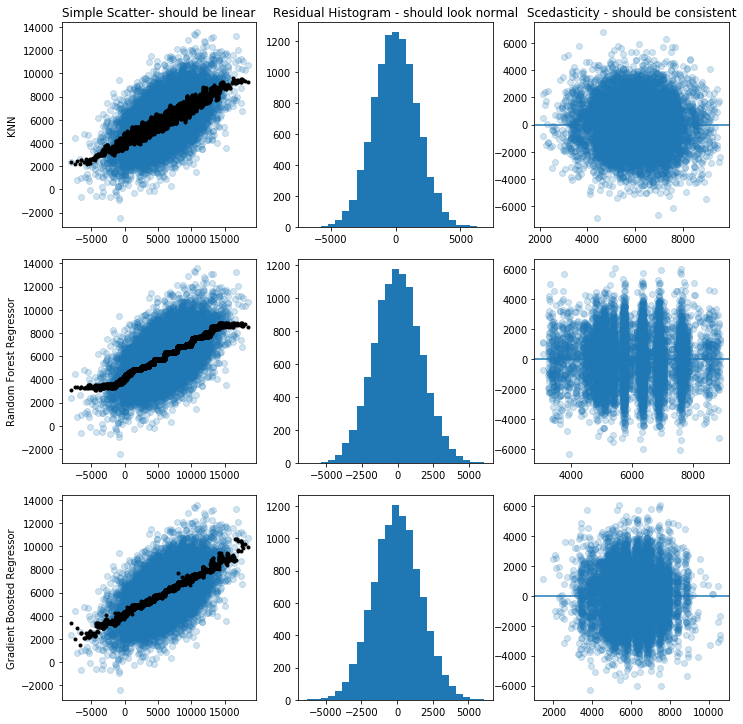

In [42]:
#Let's check how our output looks:
pred = cross_val_predict(knn,pd.DataFrame(x),y,cv=10)
residual = y - pred

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
fig.tight_layout()
plt.subplot(331)
plt.scatter(x,y, alpha=.2)
plt.plot(x, pred, '.', color='black')
plt.title('Simple Scatter- should be linear')
plt.ylabel('KNN')
plt.subplot(332)
plt.hist(residual, bins=25)
plt.title('Residual Histogram - should look normal')
plt.subplot(333)
plt.scatter(pred, residual, alpha=.2)
plt.axhline(y=0)
plt.title('Scedasticity - should be consistent')

pred = cross_val_predict(rfr,pd.DataFrame(x),y,cv=10)
residual = y - pred

plt.subplot(334)
plt.scatter(x,y, alpha=.2)
plt.plot(x, pred, '.', color='black')
plt.ylabel('Random Forest Regressor')
plt.subplot(335)
plt.hist(residual, bins=25)
plt.subplot(336)
plt.scatter(pred, residual, alpha=.2)
plt.axhline(y=0)

pred = cross_val_predict(gbr,pd.DataFrame(x),y,cv=10)
residual = y - pred

plt.subplot(337)
plt.scatter(x,y, alpha=.2)
plt.plot(x, pred, '.', color='black')
plt.ylabel('Gradient Boosted Regressor')
plt.subplot(338)
plt.hist(residual, bins=25)
plt.subplot(339)
plt.scatter(pred, residual, alpha=.2)
plt.axhline(y=0)

plt.show()

In [43]:
# Skewed Target Variable:

print("SKEWED TARGET VARIABLE:\n")
x = rightskew.df['screenActions']
y = rightskew.df['hoursSpent']
knn = neighbors.KNeighborsRegressor(n_neighbors=30)
knn.fit(pd.DataFrame(x),y)
scores = cross_val_score(knn,pd.DataFrame(x),y,cv=10)
print("KNN: ",scores)
print("\nAverage Score with 30 neighbors: ",np.mean(scores))
print('\n','-'*40)

rfr = ensemble.RandomForestRegressor(n_estimators=10, max_depth=3)
rfr.fit(pd.DataFrame(x),y)
scores = cross_val_score(rfr,pd.DataFrame(x),y,cv=10)
print("Random Forest Regressor: ",scores)
print("\nAverage Score: ",np.mean(scores))
print('\n','-'*40)

gbr = ensemble.GradientBoostingRegressor(loss='ls', learning_rate=.1, max_depth=2, n_estimators=100)
gbr.fit(pd.DataFrame(x),y)
scores = cross_val_score(gbr,pd.DataFrame(x),y,cv=10)
print("Gradient-Boosted Regressor: ",scores)
print("\nAverage Score: ",np.mean(scores))
print('\n','-'*40)

NORMAL:

KNN:  [0.29434066 0.29937416 0.23816022 0.2879878  0.23043955 0.29096608
 0.27370432 0.24105804 0.27112242 0.28383633]

Average Score with 30 neighbors:  0.27109895815154095

 ----------------------------------------
Random Forest Regressor:  [0.30944    0.30972733 0.24805636 0.30280326 0.25160615 0.29524324
 0.28003784 0.25955497 0.29079575 0.29171163]

Average Score:  0.2838976531849877

 ----------------------------------------
Gradient-Boosted Regressor:  [0.30972133 0.30571806 0.252624   0.2985733  0.25410086 0.29605828
 0.28513694 0.26641579 0.29056805 0.2937767 ]

Average Score:  0.28526932880196454

 ----------------------------------------


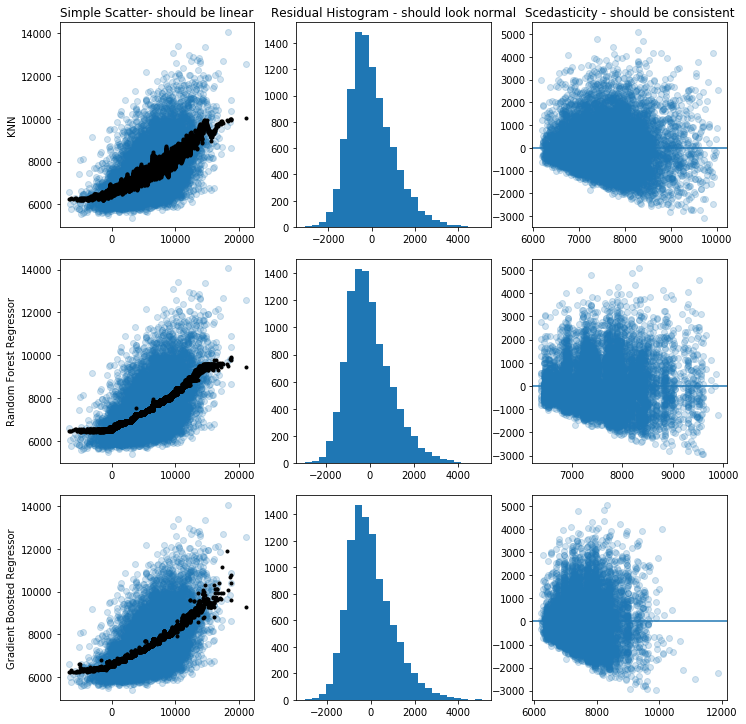

In [44]:
#Let's check how our output looks:
pred = cross_val_predict(knn,pd.DataFrame(x),y,cv=10)
residual = y - pred

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
fig.tight_layout()
plt.subplot(331)
plt.scatter(x,y, alpha=.2)
plt.plot(x, pred, '.', color='black')
plt.title('Simple Scatter- should be linear')
plt.ylabel('KNN')
plt.subplot(332)
plt.hist(residual, bins=25)
plt.title('Residual Histogram - should look normal')
plt.subplot(333)
plt.scatter(pred, residual, alpha=.2)
plt.axhline(y=0)
plt.title('Scedasticity - should be consistent')

pred = cross_val_predict(rfr,pd.DataFrame(x),y,cv=10)
residual = y - pred

plt.subplot(334)
plt.scatter(x,y, alpha=.2)
plt.plot(x, pred, '.', color='black')
plt.ylabel('Random Forest Regressor')
plt.subplot(335)
plt.hist(residual, bins=25)
plt.subplot(336)
plt.scatter(pred, residual, alpha=.2)
plt.axhline(y=0)

pred = cross_val_predict(gbr,pd.DataFrame(x),y,cv=10)
residual = y - pred

plt.subplot(337)
plt.scatter(x,y, alpha=.2)
plt.plot(x, pred, '.', color='black')
plt.ylabel('Gradient Boosted Regressor')
plt.subplot(338)
plt.hist(residual, bins=25)
plt.subplot(339)
plt.scatter(pred, residual, alpha=.2)
plt.axhline(y=0)

plt.show()

In [45]:
# Skewed Target Variable, adjusted:

print("Adjusted :\n")
x = rightskew.df['screenActions']
y = rightskew.df['cube_rt_hoursSpent']
knn = neighbors.KNeighborsRegressor(n_neighbors=30)
knn.fit(pd.DataFrame(x),y)
scores = cross_val_score(knn,pd.DataFrame(x),y,cv=10)
print("KNN: ",scores)
print("\nAverage Score with 30 neighbors: ",np.mean(scores))
print('\n','-'*40)

rfr = ensemble.RandomForestRegressor(n_estimators=10, max_depth=3)
rfr.fit(pd.DataFrame(x),y)
scores = cross_val_score(rfr,pd.DataFrame(x),y,cv=10)
print("Random Forest Regressor: ",scores)
print("\nAverage Score: ",np.mean(scores))
print('\n','-'*40)

gbr = ensemble.GradientBoostingRegressor(loss='ls', learning_rate=.1, max_depth=2, n_estimators=100)
gbr.fit(pd.DataFrame(x),y)
scores = cross_val_score(gbr,pd.DataFrame(x),y,cv=10)
print("Gradient-Boosted Regressor: ",scores)
print("\nAverage Score: ",np.mean(scores))
print('\n','-'*40)

Adjusted :

KNN:  [0.29386677 0.3016689  0.24901538 0.29353029 0.2333939  0.29567746
 0.27902309 0.25023297 0.2740268  0.28662034]

Average Score with 30 neighbors:  0.27570558997431355

 ----------------------------------------
Random Forest Regressor:  [0.30709109 0.3114828  0.2550171  0.30771149 0.25751472 0.2996326
 0.28718409 0.27132563 0.28812957 0.29297902]

Average Score:  0.287806810201384

 ----------------------------------------
Gradient-Boosted Regressor:  [0.30907029 0.3115685  0.26369566 0.30502987 0.25709807 0.30266404
 0.28985216 0.27506251 0.29321617 0.29645731]

Average Score:  0.2903714570528921

 ----------------------------------------


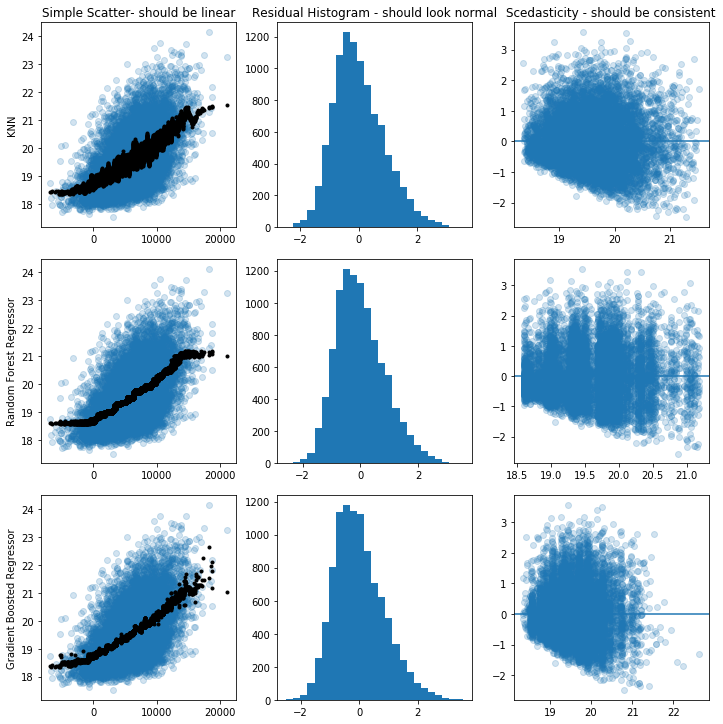

In [46]:
#Let's check how our output looks:
pred = cross_val_predict(knn,pd.DataFrame(x),y,cv=10)
residual = y - pred

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
fig.tight_layout()
plt.subplot(331)
plt.scatter(x,y, alpha=.2)
plt.plot(x, pred, '.', color='black')
plt.title('Simple Scatter- should be linear')
plt.ylabel('KNN')
plt.subplot(332)
plt.hist(residual, bins=25)
plt.title('Residual Histogram - should look normal')
plt.subplot(333)
plt.scatter(pred, residual, alpha=.2)
plt.axhline(y=0)
plt.title('Scedasticity - should be consistent')

pred = cross_val_predict(rfr,pd.DataFrame(x),y,cv=10)
residual = y - pred

plt.subplot(334)
plt.scatter(x,y, alpha=.2)
plt.plot(x, pred, '.', color='black')
plt.ylabel('Random Forest Regressor')
plt.subplot(335)
plt.hist(residual, bins=25)
plt.subplot(336)
plt.scatter(pred, residual, alpha=.2)
plt.axhline(y=0)

pred = cross_val_predict(gbr,pd.DataFrame(x),y,cv=10)
residual = y - pred

plt.subplot(337)
plt.scatter(x,y, alpha=.2)
plt.plot(x, pred, '.', color='black')
plt.ylabel('Gradient Boosted Regressor')
plt.subplot(338)
plt.hist(residual, bins=25)
plt.subplot(339)
plt.scatter(pred, residual, alpha=.2)
plt.axhline(y=0)

plt.show()

# Summary of 1-variable linear regression:
- 30% accurate when both dependent and independent variables are normally distributed
- If the Target Variable has a right skew, we lose 3% of accuracy, and additionally our model loses validity; our residuals tend to be large positives, and are much larger when the input variable is bigger.
- Cube-rooting the target variable to reduce the skew doesn't improve the R-squared score, but it does somewhat normalize residuals and scedasticity, which is useful.

KNN, Random Forest, and Gradient boosted regressors don't necessarily improve on the accuracy of simple linear regression, but they do seem to reduce the effects of a skewed target variable - in particular, Random Forest seems to extrapolate to the tail data better than any other model.


---------
# Attempting Linear Variable Regression with other data types

for i in range(10,50,5):
    rfr = ensemble.RandomForestRegressor(n_estimators=i, max_depth=3)
    rfr.fit(pd.DataFrame(x),y)
    scores = cross_val_score(rfr,pd.DataFrame(x),y,cv=10)
    print("\nAverage Score: ",np.mean(scores))

work  in bayesian vs frequentist thinking
p values, priors etc.

logistic regression (over/under x hours?) to discuss ROC